In [24]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'


## Exclusions and Outliers
-- 3 subject sub-5f706a963b6ac2627a4bb3b5 & sub-611c31c77df20ecc6881cc44 reported 0 variance distributions

In [27]:


sub_df=[]
subs=os.listdir('../bids')
for sub in subs:
    #print(sub)
    if sub not in['subjects.tsv','sub-5f706a963b6ac2627a4bb3b5','sub-611c31c77df20ecc6881cc44',
                 'sub-5d8aa95dd06260000179442b']:#reported 0 variance distributions
        mem=pd.read_csv('../bids/%s/%s_mem-report.tsv'%(sub,sub),sep='\t')
        if len(mem.groupby('dist').mean())<2:
            print("didn't answer for all dists",sub)
        else:
            vals=[]
            for dist in ['narrow','wide','skew']:
                vals.append(len(mem[(mem['dist']=='wide')&(mem['value']>0)]))
            if any([val<2 for val in vals]):
                print("non zero std ",sub)
            else:
                mem.percent=mem.percent.astype(int)

                mem['value']=mem['value'].astype(int)
                mem.loc[mem['value'] < 0, 'value'] = 0
                mem=pd.DataFrame(mem.values.repeat(mem.value, axis=0), columns=mem.columns)
                mem.percent=mem.percent.astype(int)
                mem['order']=mem['order'].astype(int)
                mem['value']=mem['value'].astype(int)
                mem=mem[['dist','percent','value','order']]
                O_df=mem.groupby('dist').mean().reset_index()
                order_var=O_df[O_df['dist']=='wide']['order'].values-O_df[O_df['dist']=='narrow']['order'].values
                if len(mem.groupby('dist').mean())>2:
                    mem_df=pd.DataFrame()
                    mem_df['dist']=['narrow','skew','wide']
                    mem_df['narrow_first']=order_var[0]
                    mem_df['means']=mem.groupby('dist').mean()['percent'].values
                    mem_df['stds']=mem.groupby('dist').std()['percent'].values
                    mem_df['skew']=mem.groupby('dist').skew()['percent'].values
                    mem_df['sub']=(sub)
                    sub_df.append(mem_df)
                else:
                    #print(sub)
                    pass
sub_df=pd.concat(sub_df)
sub_df=sub_df.reset_index()


non zero std  sub-5c92870723bd7e001870138e
non zero std  sub-64270a5159f257ca7fb39155
non zero std  sub-5cb34fdb9a26a300017302d8
non zero std  sub-5fa315662ca5b25d05ae8236
non zero std  sub-6428f7ac297e312f7262d93b
non zero std  sub-56c8915edfea6c000cb29c98
non zero std  sub-62897d2024f826ea90b7efa1
non zero std  sub-5dd3eb4bc0823f3d043b96fb
non zero std  sub-62ff26509176c97c9ceebc2b
non zero std  sub-63782709326973c77adc3db8
non zero std  sub-5ec97fd040ce7448f367784b
non zero std  sub-5c8198fcf29fd90001a2b9c9
non zero std  sub-63f2e107c4d0bc684b99d2c6
non zero std  sub-5bdc8d12b2fff7000189b6f8
non zero std  sub-63d4d6434407b2b392e65863
non zero std  sub-637d4793730be3ac44f5a4a5


In [28]:
import statsmodels.api as sm
row=[]
exclude=[]
for sub in sub_df['sub'].unique():
    df=pd.read_csv('../bids/%s/%s_task-amb_run-1_events.tsv'%(sub,sub),
                   sep='\t')
    if any(df[df['choice']=='risk']['per']==0):
        exclude.append(sub)
    elif any(df[df['choice']=='Ambiguity']['per']==1):
        exclude.append(sub)
    
print("Out of %s participants an additional %s were excluded do to choice checks"%(len(
    sub_df['sub'].unique()),len(exclude)))
print("This leaves us with a total of %s"%(len(
    sub_df['sub'].unique())-len(exclude)))
sub_df=sub_df[~sub_df['sub'].isin(exclude)]
df=pd.read_csv('../bids/subjects.tsv',sep='\t')
df=df[df['sub'].isin(sub_df['sub'].values)].reset_index()
sub_df=sub_df.merge(df,left_on='sub',right_on='sub')
sub_df.head()

Out of 285 participants an additional 15 were excluded do to choice checks
This leaves us with a total of 270


,index_x,dist,narrow_first,means,stds,skew,sub,index_y,USIDep,AQ_Social,AQ_AttnDet,AQ_AttnSwitch,AQ_Commun,AQ_Imagine,AQ_total,age,education,sex,race
0,0,narrow,-1.0,50.000000,33.166248,0.000000,sub-5858b2ca83a02d0001e38fd2,111,1,4.2,6.6,5.8,5.0,4.2,25.8,44,Bachelor's Degree,Male,White / Caucasian
1,1,skew,-1.0,71.764706,14.677915,-0.209272,sub-5858b2ca83a02d0001e38fd2,111,1,4.2,6.6,5.8,5.0,4.2,25.8,44,Bachelor's Degree,Male,White / Caucasian
2,2,wide,-1.0,48.000000,36.292463,0.123724,sub-5858b2ca83a02d0001e38fd2,111,1,4.2,6.6,5.8,5.0,4.2,25.8,44,Bachelor's Degree,Male,White / Caucasian
3,0,narrow,-1.0,59.166667,19.286516,0.505403,sub-5c7e764fa7432a00169e1499,407,1,5.2,7.0,5.2,4.8,4.6,26.8,44,Bachelor's Degree,Male,Black or African American
4,1,skew,-1.0,47.058824,27.102746,-0.458493,sub-5c7e764fa7432a00169e1499,407,1,5.2,7.0,5.2,4.8,4.6,26.8,44,Bachelor's Degree,Male,Black or African American


## Hypothesis 3 a:
- Autistic traits measured by the autism quotient, will be negatively correlated ambiguity aversion. 
- Choice ~ Probability + Autistic Trait 

In [29]:
sub_df[sub_df['sub']==sub][['AQ_Social','AQ_AttnDet','AQ_AttnSwitch','AQ_Commun','AQ_Imagine','AQ_total']].values[0]

array([ 6.2,  3.8,  6.6,  5.6,  5.8, 28. ])

In [30]:
amb_df=[]
for sub in sub_df['sub'].unique():
    #print(sub)
    amb=pd.read_csv('../bids/%s/%s_task-amb_run-1_events.tsv'%(sub,sub),sep='\t')
    amb['sub']=sub
    amb['order']=sub_df[sub_df['sub']==sub]['narrow_first'].values[0]
    amb[['AQ_Social','AQ_AttnDet','AQ_AttnSwitch','AQ_Commun','AQ_Imagine','AQ_total']]=sub_df[
        sub_df['sub']==sub][
        ['AQ_Social','AQ_AttnDet','AQ_AttnSwitch','AQ_Commun','AQ_Imagine','AQ_total']].values[0]
    
    amb_df.append(amb)
        
amb_df=pd.concat(amb_df)
print("no NA values for choice ",amb_df['choice'].unique())
amb_df['choose_risk']=amb_df['choice']=='risk'
print("no NA values for Amb ",amb_df['Amb'].unique())
amb_df['full_A']=amb_df['Amb']=='[0,1]'
print("no NA values for dist ",amb_df['dist'].unique())
amb_df['wide_dist']=amb_df['dist']=='wide'
print("NA values for percent ",any(amb_df['per'].isna()))


amb_df.head()

no NA values for choice  ['risk' 'Ambiguous']
no NA values for Amb  ['[0.25,0.75]' '[0,1]']
no NA values for dist  ['wide' 'narrow' 'skew']
NA values for percent  False


,Blocktype,tnum,rt,color,per,Amb,choice,dist,side,response,...,order,AQ_Social,AQ_AttnDet,AQ_AttnSwitch,AQ_Commun,AQ_Imagine,AQ_total,choose_risk,full_A,wide_dist
0,Ambiguity,0.0,1666.0,blue,0.50,"[0.25,0.75]",risk,wide,right,j,...,-1.0,4.2,6.6,5.8,5.0,4.2,25.8,True,False,True
1,Ambiguity,1.0,2371.0,blue,0.41,"[0.25,0.75]",Ambiguous,wide,right,f,...,-1.0,4.2,6.6,5.8,5.0,4.2,25.8,False,False,True
2,Ambiguity,2.0,1480.0,blue,0.46,"[0.25,0.75]",risk,wide,left,f,...,-1.0,4.2,6.6,5.8,5.0,4.2,25.8,True,False,True
3,Ambiguity,3.0,1457.0,blue,0.42,"[0.25,0.75]",Ambiguous,wide,right,f,...,-1.0,4.2,6.6,5.8,5.0,4.2,25.8,False,False,True
4,Ambiguity,4.0,1914.0,blue,0.43,"[0.25,0.75]",Ambiguous,wide,right,f,...,-1.0,4.2,6.6,5.8,5.0,4.2,25.8,False,False,True


In [31]:
from pymer4.models import Lmer
model_df=amb_df[amb_df['full_A']==True]

aqs=[aq for aq in model_df.columns if aq.startswith('AQ_')]

for dist in model_df['dist'].unique():
    tmp=model_df[model_df['dist'].isin([dist])]
    for aq in aqs:
        print("####### %s   %s #######"%(aq,dist))
        model = Lmer("choose_risk  ~ per+%s  + (1|sub)"%(aq),
                     data=tmp, family = 'binomial')
        display(model.fit(robust='hcl'))


####### AQ_Social   wide #######
Formula: choose_risk~per+AQ_Social+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2425.124 	 AIC: 4858.247

Random effects:

            Name     Var   Std
sub  (Intercept)  10.049  3.17

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-9.972,-11.952,-7.993,1.010,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.0,0.000,-9.874,0.000,***
per,21.548,19.148,23.947,1.224,2.280180e+09,2.069010e+08,2.512903e+10,1.000,1.0,1.000,17.599,0.000,***
AQ_Social,-0.125,-0.407,0.156,0.144,8.820000e-01,6.660000e-01,1.169000e+00,0.469,0.4,0.539,-0.873,0.383,


####### AQ_AttnDet   wide #######
Formula: choose_risk~per+AQ_AttnDet+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2424.724 	 AIC: 4857.448

Random effects:

            Name    Var    Std
sub  (Intercept)  10.01  3.164

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-11.896,-14.221,-9.571,1.186,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-10.028,0.000,***
per,21.543,19.143,23.943,1.224,2.270120e+09,2.060047e+08,2.501614e+10,1.000,1.000,1.000,17.595,0.000,***
AQ_AttnDet,0.198,-0.113,0.510,0.159,1.220000e+00,8.930000e-01,1.665000e+00,0.549,0.472,0.625,1.249,0.212,


####### AQ_AttnSwitch   wide #######
Formula: choose_risk~per+AQ_AttnSwitch+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2425.422 	 AIC: 4858.844

Random effects:

            Name     Var    Std
sub  (Intercept)  10.069  3.173

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-11.171,-13.822,-8.520,1.353,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-8.259,0.000,***
per,21.543,19.144,23.942,1.224,2.269382e+09,2.060769e+08,2.499112e+10,1.000,1.000,1.000,17.600,0.000,***
AQ_AttnSwitch,0.078,-0.297,0.452,0.191,1.081000e+00,7.430000e-01,1.572000e+00,0.519,0.426,0.611,0.407,0.684,


####### AQ_Commun   wide #######
Formula: choose_risk~per+AQ_Commun+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2425.336 	 AIC: 4858.672

Random effects:

            Name    Var    Std
sub  (Intercept)  10.06  3.172

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-10.140,-12.330,-7.949,1.118,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-9.073,0.000,***
per,21.541,19.139,23.943,1.225,2.265415e+09,2.051313e+08,2.501863e+10,1.000,1.000,1.000,17.578,0.000,***
AQ_Commun,-0.106,-0.462,0.251,0.182,9.000000e-01,6.300000e-01,1.285000e+00,0.474,0.386,0.562,-0.582,0.561,


####### AQ_Imagine   wide #######
Formula: choose_risk~per+AQ_Imagine+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2425.490 	 AIC: 4858.980

Random effects:

            Name    Var    Std
sub  (Intercept)  10.07  3.173

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-10.521,-12.772,-8.269,1.149,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-9.159,0.000,***
per,21.539,19.139,23.939,1.224,2.260783e+09,2.051112e+08,2.491887e+10,1.000,1.000,1.000,17.590,0.000,***
AQ_Imagine,-0.035,-0.425,0.356,0.199,9.660000e-01,6.540000e-01,1.427000e+00,0.491,0.395,0.588,-0.174,0.862,


####### AQ_total   wide #######
Formula: choose_risk~per+AQ_total+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2425.505 	 AIC: 4859.010

Random effects:

            Name     Var    Std
sub  (Intercept)  10.073  3.174

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-10.676,-13.663,-7.689,1.524,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000,0.000,-7.006,0.000,***
per,21.541,19.140,23.942,1.225,2.264930e+09,2.053270e+08,2.498408e+10,1.0,1.000,1.000,17.586,0.000,***
AQ_total,-0.000,-0.098,0.097,0.050,1.000000e+00,9.070000e-01,1.101000e+00,0.5,0.476,0.524,-0.009,0.993,


####### AQ_Social   narrow #######
Formula: choose_risk~per+AQ_Social+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2356.494 	 AIC: 4720.989

Random effects:

            Name     Var    Std
sub  (Intercept)  10.808  3.287

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-11.057,-13.113,-9.002,1.049,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-10.542,0.000,***
per,24.126,21.633,26.619,1.272,3.004653e+10,2.483615e+09,3.634999e+11,1.000,1.000,1.000,18.967,0.000,***
AQ_Social,0.005,-0.287,0.296,0.149,1.005000e+00,7.510000e-01,1.344000e+00,0.501,0.429,0.573,0.031,0.975,


####### AQ_AttnDet   narrow #######
Formula: choose_risk~per+AQ_AttnDet+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2356.424 	 AIC: 4720.849

Random effects:

            Name     Var    Std
sub  (Intercept)  10.801  3.287

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-11.407,-13.717,-9.098,1.178,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-9.681,0.000,***
per,24.126,21.632,26.621,1.273,3.005280e+10,2.480412e+09,3.641213e+11,1.000,1.000,1.000,18.956,0.000,***
AQ_AttnDet,0.062,-0.261,0.385,0.165,1.064000e+00,7.710000e-01,1.469000e+00,0.515,0.435,0.595,0.376,0.707,


####### AQ_AttnSwitch   narrow #######
Formula: choose_risk~per+AQ_AttnSwitch+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2356.091 	 AIC: 4720.183

Random effects:

            Name     Var    Std
sub  (Intercept)  10.779  3.283

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-12.132,-14.855,-9.409,1.389,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-8.733,0.000,***
per,24.131,21.641,26.622,1.271,3.020222e+10,2.502937e+09,3.644416e+11,1.000,1.000,1.000,18.991,0.000,***
AQ_AttnSwitch,0.177,-0.210,0.565,0.198,1.194000e+00,8.110000e-01,1.759000e+00,0.544,0.448,0.638,0.898,0.369,


####### AQ_Commun   narrow #######
Formula: choose_risk~per+AQ_Commun+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2356.483 	 AIC: 4720.966

Random effects:

            Name     Var    Std
sub  (Intercept)  10.807  3.287

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-11.183,-13.445,-8.920,1.154,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-9.689,0.000,***
per,24.126,21.634,26.619,1.272,3.006055e+10,2.485047e+09,3.636296e+11,1.000,1.000,1.000,18.969,0.000,***
AQ_Commun,0.029,-0.340,0.398,0.188,1.030000e+00,7.120000e-01,1.489000e+00,0.507,0.416,0.598,0.155,0.877,


####### AQ_Imagine   narrow #######
Formula: choose_risk~per+AQ_Imagine+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2356.491 	 AIC: 4720.981

Random effects:

            Name     Var    Std
sub  (Intercept)  10.808  3.287

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-11.124,-13.424,-8.824,1.174,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-9.478,0.000,***
per,24.127,21.629,26.625,1.275,3.006519e+10,2.472873e+09,3.655326e+11,1.000,1.000,1.000,18.930,0.000,***
AQ_Imagine,0.019,-0.385,0.424,0.206,1.019000e+00,6.800000e-01,1.528000e+00,0.505,0.405,0.604,0.093,0.926,


####### AQ_total   narrow #######
Formula: choose_risk~per+AQ_total+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2356.404 	 AIC: 4720.808

Random effects:

            Name     Var    Std
sub  (Intercept)  10.803  3.287

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-11.645,-14.735,-8.556,1.576,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.00,0.000,-7.388,0.000,***
per,24.129,21.641,26.618,1.270,3.014130e+10,2.502397e+09,3.630511e+11,1.000,1.00,1.000,19.003,0.000,***
AQ_total,0.022,-0.079,0.123,0.051,1.022000e+00,9.240000e-01,1.130000e+00,0.505,0.48,0.531,0.425,0.671,


####### AQ_Social   skew #######
Formula: choose_risk~per+AQ_Social+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2363.910 	 AIC: 4735.820

Random effects:

            Name     Var    Std
sub  (Intercept)  13.236  3.638

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-11.678,-13.905,-9.451,1.136,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-10.278,0.000,***
per,25.656,23.029,28.283,1.340,1.387166e+11,1.003031e+10,1.918413e+12,1.000,1.000,1.000,19.143,0.000,***
AQ_Social,-0.309,-0.632,0.014,0.165,7.340000e-01,5.320000e-01,1.014000e+00,0.423,0.347,0.504,-1.874,0.061,.


####### AQ_AttnDet   skew #######
Formula: choose_risk~per+AQ_AttnDet+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2364.068 	 AIC: 4736.135

Random effects:

            Name    Var    Std
sub  (Intercept)  13.27  3.643

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-15.445,-18.162,-12.727,1.387,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-11.139,0.000,***
per,25.669,23.040,28.298,1.341,1.405930e+11,1.014159e+10,1.949043e+12,1.000,1.000,1.000,19.135,0.000,***
AQ_AttnDet,0.327,-0.032,0.686,0.183,1.387000e+00,9.690000e-01,1.985000e+00,0.581,0.492,0.665,1.786,0.074,.


####### AQ_AttnSwitch   skew #######
Formula: choose_risk~per+AQ_AttnSwitch+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2365.657 	 AIC: 4739.315

Random effects:

            Name     Var    Std
sub  (Intercept)  13.407  3.662

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-13.220,-16.244,-10.196,1.543,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-8.568,0.00,***
per,25.640,23.008,28.272,1.343,1.365247e+11,9.822678e+09,1.897547e+12,1.000,1.000,1.000,19.094,0.00,***
AQ_AttnSwitch,-0.036,-0.467,0.394,0.220,9.650000e-01,6.270000e-01,1.484000e+00,0.491,0.385,0.597,-0.164,0.87,


####### AQ_Commun   skew #######
Formula: choose_risk~per+AQ_Commun+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2364.945 	 AIC: 4737.890

Random effects:

            Name     Var    Std
sub  (Intercept)  13.335  3.652

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-12.140,-14.629,-9.651,1.270,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.00,0.000,-9.559,0.000,***
per,25.645,23.013,28.277,1.343,1.372225e+11,9.868527e+09,1.908089e+12,1.000,1.00,1.000,19.095,0.000,***
AQ_Commun,-0.252,-0.662,0.158,0.209,7.770000e-01,5.160000e-01,1.171000e+00,0.437,0.34,0.539,-1.204,0.229,


####### AQ_Imagine   skew #######
Formula: choose_risk~per+AQ_Imagine+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2364.809 	 AIC: 4737.619

Random effects:

            Name     Var   Std
sub  (Intercept)  13.319  3.65

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-11.992,-14.510,-9.473,1.285,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-9.333,0.00,***
per,25.638,23.010,28.266,1.341,1.362602e+11,9.844150e+09,1.886079e+12,1.000,1.000,1.000,19.123,0.00,***
AQ_Imagine,-0.300,-0.748,0.148,0.229,7.410000e-01,4.730000e-01,1.160000e+00,0.426,0.321,0.537,-1.312,0.19,


####### AQ_total   skew #######
Formula: choose_risk~per+AQ_total+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2365.361 	 AIC: 4738.723

Random effects:

            Name     Var    Std
sub  (Intercept)  13.373  3.657

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-12.186,-15.573,-8.798,1.728,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-7.051,0.000,***
per,25.637,23.010,28.264,1.340,1.362031e+11,9.846118e+09,1.884120e+12,1.000,1.000,1.000,19.127,0.000,***
AQ_total,-0.045,-0.156,0.067,0.057,9.560000e-01,8.550000e-01,1.069000e+00,0.489,0.461,0.517,-0.788,0.431,


## Hypothesis 3 b:
- Autistic traits will be negatively correlated with the variance of individual’s reported belief about the distribution of probabilities.

In [32]:
model_df=amb_df[(amb_df['full_A']==True)&(amb_df['dist']=='narrow')]

model = Lmer("choose_risk  ~ per+(1+per|sub)",
             data=model_df, family = 'binomial')

model.fit(robust='hcl')

fixedEFF_df=model.fixef.reset_index()
fixedEFF_df=fixedEFF_df.rename(columns={'index':'sub'})
sub_df=sub_df.merge(fixedEFF_df[['sub','(Intercept)','per']],on='sub')
sub_df.head()

Formula: choose_risk~per+(1+per|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2139.565 	 AIC: 4289.130

Random effects:

            Name       Var     Std
sub  (Intercept)   391.919  19.797
sub          per  1476.980  38.431

             IV1  IV2   Corr
sub  (Intercept)  per -0.977

Fixed effects:



,index_x,dist,narrow_first,means,stds,skew,sub,index_y,USIDep,AQ_Social,...,AQ_AttnSwitch,AQ_Commun,AQ_Imagine,AQ_total,age,education,sex,race,(Intercept),per
0,0,narrow,-1.0,50.000000,33.166248,0.000000,sub-5858b2ca83a02d0001e38fd2,111,1,4.2,...,5.8,5.0,4.2,25.8,44,Bachelor's Degree,Male,White / Caucasian,-46.869410,93.313178
1,1,skew,-1.0,71.764706,14.677915,-0.209272,sub-5858b2ca83a02d0001e38fd2,111,1,4.2,...,5.8,5.0,4.2,25.8,44,Bachelor's Degree,Male,White / Caucasian,-46.869410,93.313178
2,2,wide,-1.0,48.000000,36.292463,0.123724,sub-5858b2ca83a02d0001e38fd2,111,1,4.2,...,5.8,5.0,4.2,25.8,44,Bachelor's Degree,Male,White / Caucasian,-46.869410,93.313178
3,0,narrow,-1.0,59.166667,19.286516,0.505403,sub-5c7e764fa7432a00169e1499,407,1,5.2,...,5.2,4.8,4.6,26.8,44,Bachelor's Degree,Male,Black or African American,-47.341955,95.679455
4,1,skew,-1.0,47.058824,27.102746,-0.458493,sub-5c7e764fa7432a00169e1499,407,1,5.2,...,5.2,4.8,4.6,26.8,44,Bachelor's Degree,Male,Black or African American,-47.341955,95.679455


/home/strange/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/strange/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/strange/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

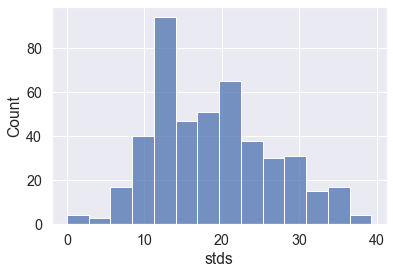

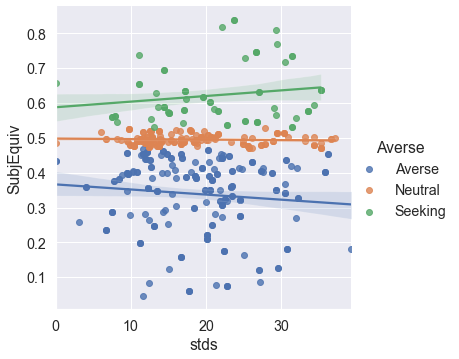

In [33]:
plt_df=sub_df[sub_df['dist']=='narrow']
plt_df['AQ_Cutoff']=plt_df['AQ_total']>32

plt_df['SubjEquiv']=np.divide(-plt_df['(Intercept)'],plt_df['per'])
plt_df['Averse']=pd.cut(plt_df['SubjEquiv'],bins=[0,.47,.53,1.00],labels=['Averse','Neutral','Seeking'])

plt_df=plt_df[(plt_df['SubjEquiv']>0)&(plt_df['SubjEquiv']<1)]

plt_df['var_high']=pd.cut(plt_df['stds'],bins=[0,10,20,30,40])#,labels=['low','medium','high'])
plt_df['mean_high']=pd.cut(plt_df['means'],bins=[0,45,55,100],labels=['low','medium','high'])
sns.histplot(x='stds',data=plt_df)
plt.show()
sns.lmplot(y='SubjEquiv',x='stds',order=1,hue='Averse',data=plt_df)
plt.show()

R: 0.013216940620090514 P: 0.6760882362885491


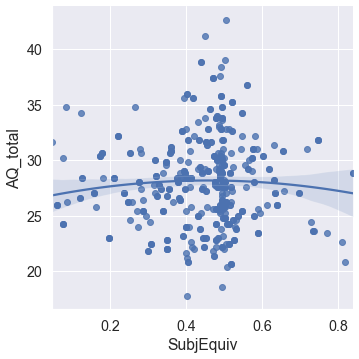

In [34]:
from scipy.stats import pearsonr, spearmanr, kendalltau, zscore, shapiro

r,p=kendalltau(plt_df['AQ_total']**2,plt_df['SubjEquiv'])
print("R: %s P: %s"%(r,p))
sns.lmplot(x='SubjEquiv',y='AQ_total',order=2,data=plt_df)

NEW DIST narrow 

AQ_Social
Normality AQ Statistics=0.990, p=0.086
Normality stds Statistics=0.974, p=0.000
Kendal Tau: -0.12182575176059882 P: 0.0041871341593736015
Pearson R: -0.16616105582122576 P: 0.007481846897231492


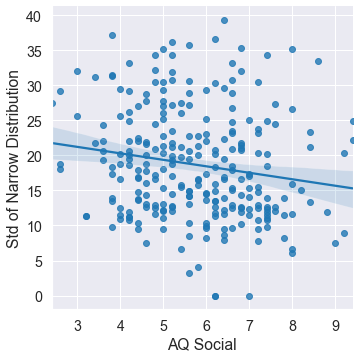

AQ_AttnDet
Normality AQ Statistics=0.985, p=0.010
Normality stds Statistics=0.974, p=0.000
Kendal Tau: 0.015525960040131476 P: 0.7156538531344361
Pearson R: 0.03322980183295937 P: 0.5952076955326178


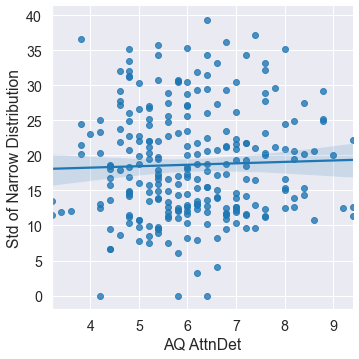

AQ_AttnSwitch
Normality AQ Statistics=0.986, p=0.015
Normality stds Statistics=0.974, p=0.000
Kendal Tau: -0.1070955516660736 P: 0.012398362380928079
Pearson R: -0.14903880883600537 P: 0.016589179840624274


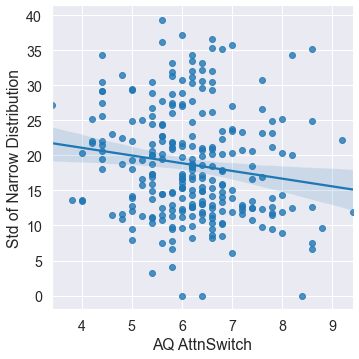

AQ_Commun
Normality AQ Statistics=0.989, p=0.053
Normality stds Statistics=0.974, p=0.000
Kendal Tau: -0.13209567833125554 P: 0.002004087546465951
Pearson R: -0.17240922430112962 P: 0.005491759896653221


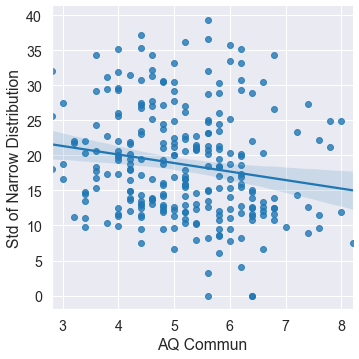

AQ_Imagine
Normality AQ Statistics=0.984, p=0.006
Normality stds Statistics=0.974, p=0.000
Kendal Tau: -0.06108630115952848 P: 0.15361521548704452
Pearson R: -0.0689126492384786 P: 0.2700976386748285


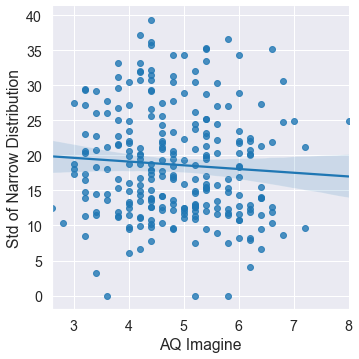

AQ_total
Normality AQ Statistics=0.986, p=0.011
Normality stds Statistics=0.974, p=0.000
Kendal Tau: -0.12723467062836866 P: 0.0024738666718569073
Pearson R: -0.14990381404886444 P: 0.0159633827224671


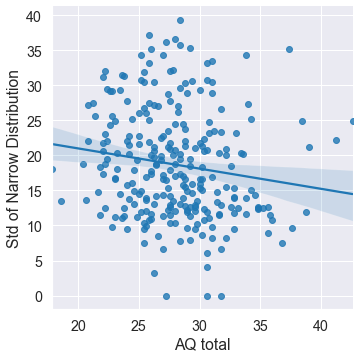

NEW DIST skew 

AQ_Social
Normality AQ Statistics=0.990, p=0.086
Normality stds Statistics=0.983, p=0.004
Kendal Tau: -0.025571320968674337 P: 0.5477000200019179
Pearson R: -0.023482812487007333 P: 0.707355538921491


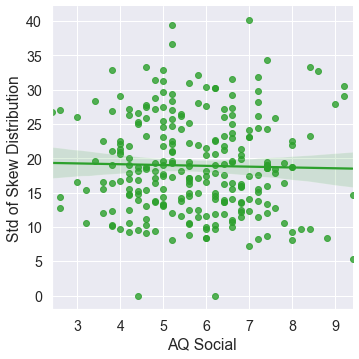

AQ_AttnDet
Normality AQ Statistics=0.985, p=0.010
Normality stds Statistics=0.983, p=0.004
Kendal Tau: -0.004034725868716604 P: 0.924567573007543
Pearson R: -0.013745765505808406 P: 0.8260830285927977


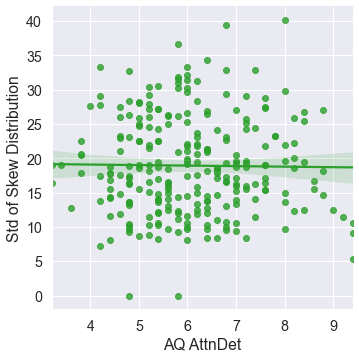

AQ_AttnSwitch
Normality AQ Statistics=0.986, p=0.015
Normality stds Statistics=0.983, p=0.004
Kendal Tau: -0.08687998312149703 P: 0.04246128114412303
Pearson R: -0.10666654481753789 P: 0.08728800103026797


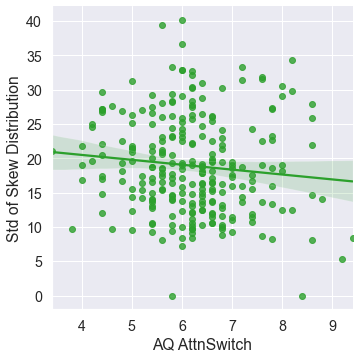

AQ_Commun
Normality AQ Statistics=0.989, p=0.053
Normality stds Statistics=0.983, p=0.004
Kendal Tau: -0.039314941827909365 P: 0.35771602601517793
Pearson R: -0.03526029279945155 P: 0.5728974856529565


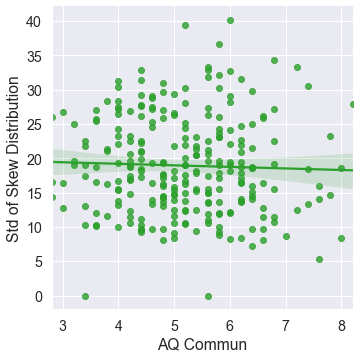

AQ_Imagine
Normality AQ Statistics=0.984, p=0.006
Normality stds Statistics=0.983, p=0.004
Kendal Tau: 0.05670965726280587 P: 0.1852040568891532
Pearson R: 0.07595821975701258 P: 0.224022020632697


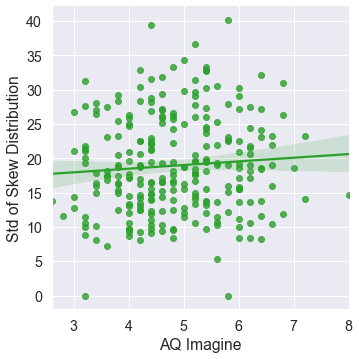

AQ_total
Normality AQ Statistics=0.986, p=0.011
Normality stds Statistics=0.983, p=0.004
Kendal Tau: -0.032682457773698444 P: 0.4368260497497952
Pearson R: -0.030799574094924898 P: 0.6224160813212847


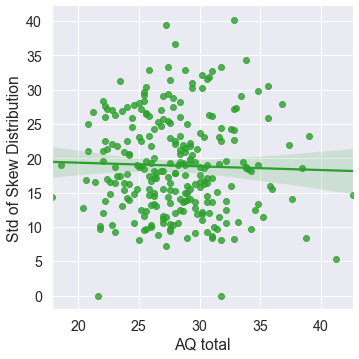

NEW DIST wide 

AQ_Social
Normality AQ Statistics=0.990, p=0.086
Normality stds Statistics=0.963, p=0.000
Kendal Tau: 0.01945392966996922 P: 0.6473759801842249
Pearson R: -0.011037069320983181 P: 0.8599591901004985


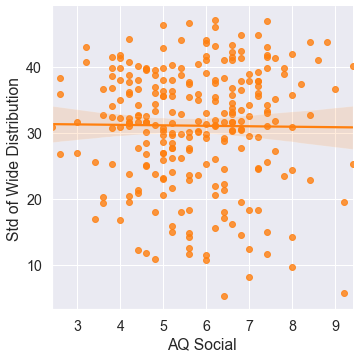

AQ_AttnDet
Normality AQ Statistics=0.985, p=0.010
Normality stds Statistics=0.963, p=0.000
Kendal Tau: 0.07548485804566597 P: 0.07647971894132316
Pearson R: 0.11146195590871158 P: 0.07390135083590466


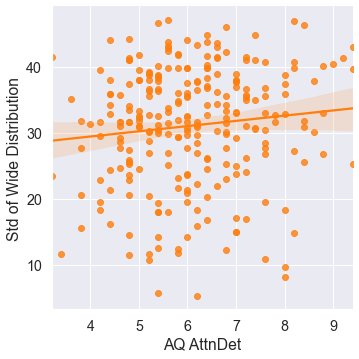

AQ_AttnSwitch
Normality AQ Statistics=0.986, p=0.015
Normality stds Statistics=0.963, p=0.000
Kendal Tau: 0.05361147109817923 P: 0.21053296326970428
Pearson R: 0.04388558382023392 P: 0.4827900627474909


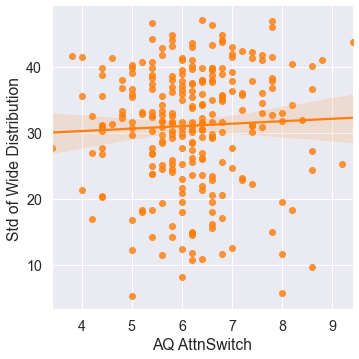

AQ_Commun
Normality AQ Statistics=0.989, p=0.053
Normality stds Statistics=0.963, p=0.000
Kendal Tau: 0.08109762785300242 P: 0.05778915556965273
Pearson R: 0.10299265943855834 P: 0.09880669423220288


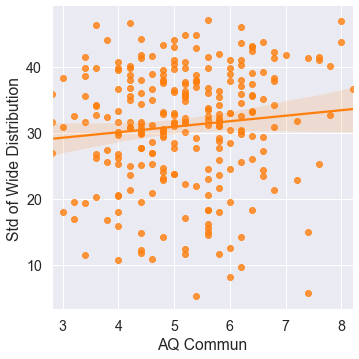

AQ_Imagine
Normality AQ Statistics=0.984, p=0.006
Normality stds Statistics=0.963, p=0.000
Kendal Tau: 0.05057750476521103 P: 0.23732238084401458
Pearson R: 0.0508622959006289 P: 0.4159147606228421


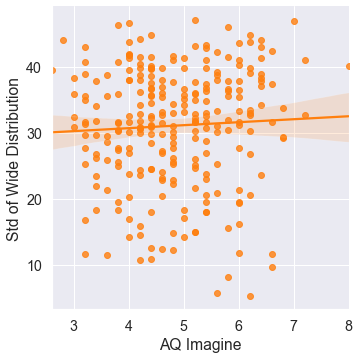

AQ_total
Normality AQ Statistics=0.986, p=0.011
Normality stds Statistics=0.963, p=0.000
Kendal Tau: 0.08766380994683434 P: 0.036998990653475054
Pearson R: 0.08306060819777103 P: 0.1835275566127732


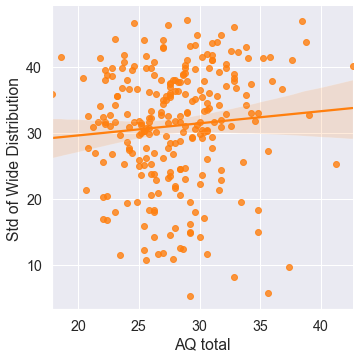

In [35]:
from scipy.stats import pearsonr, spearmanr, kendalltau, zscore, shapiro
sns.set(font_scale=1.3)

for dist in sub_df['dist'].unique():
    if dist=='narrow':
        color=[plt.cm.tab10(0)]
    if dist=='wide':
        color=[plt.cm.tab10(1)]
    if dist=='skew':
        color=[plt.cm.tab10(2)]
    print('NEW DIST', dist, '\n')
    plt_df=sub_df[sub_df['dist'].isin([dist])]
    plt_df=plt_df.groupby(by='sub').mean()
    for aq in [aq for aq in df.columns if aq.startswith('AQ_')]:
        print(aq)
        stat, p = shapiro(plt_df[aq])
        print('Normality AQ Statistics=%.3f, p=%.3f' % (stat, p))
        stat, p = shapiro(plt_df['stds'])
        print('Normality stds Statistics=%.3f, p=%.3f' % (stat, p))
        r,p=kendalltau(plt_df[aq],plt_df['stds'])
        print("Kendal Tau: %s P: %s"%(r,p))
        r,p=pearsonr(plt_df[aq],plt_df['stds'])
        print("Pearson R: %s P: %s"%(r,p))
        with sns.axes_style("darkgrid"):
            ax=sns.lmplot(x=aq,y='stds',data=plt_df,order=1,
                       line_kws={'color': color[0]}, scatter_kws={'color': color})
            ax.set_ylabels('Std of %s Distribution'%(dist.capitalize()))
            ax.set_xlabels('%s'%(aq.replace("_", " ")))
            plt.savefig("Figures/H3b_%s_%s.svg"%(dist,aq))
            plt.show()

## Model for H3C

In [36]:
model_df=amb_df[(amb_df['full_A']==True)&(amb_df['dist']=='narrow')]

model = Lmer("choose_risk  ~ per+(1+per|sub)",
             data=model_df, family = 'binomial')

model.fit(robust='hcl')

fixedEFF_df=model.fixef.reset_index()
fixedEFF_df=fixedEFF_df.rename(columns={'index':'sub'})
sub_df=sub_df.merge(fixedEFF_df[['sub','(Intercept)','per']],on='sub')
sub_df.head()

Formula: choose_risk~per+(1+per|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2139.565 	 AIC: 4289.130

Random effects:

            Name       Var     Std
sub  (Intercept)   391.919  19.797
sub          per  1476.980  38.431

             IV1  IV2   Corr
sub  (Intercept)  per -0.977

Fixed effects:



,index_x,dist,narrow_first,means,stds,skew,sub,index_y,USIDep,AQ_Social,...,AQ_Imagine,AQ_total,age,education,sex,race,(Intercept)_x,per_x,(Intercept)_y,per_y
0,0,narrow,-1.0,50.000000,33.166248,0.000000,sub-5858b2ca83a02d0001e38fd2,111,1,4.2,...,4.2,25.8,44,Bachelor's Degree,Male,White / Caucasian,-46.869410,93.313178,-46.869410,93.313178
1,1,skew,-1.0,71.764706,14.677915,-0.209272,sub-5858b2ca83a02d0001e38fd2,111,1,4.2,...,4.2,25.8,44,Bachelor's Degree,Male,White / Caucasian,-46.869410,93.313178,-46.869410,93.313178
2,2,wide,-1.0,48.000000,36.292463,0.123724,sub-5858b2ca83a02d0001e38fd2,111,1,4.2,...,4.2,25.8,44,Bachelor's Degree,Male,White / Caucasian,-46.869410,93.313178,-46.869410,93.313178
3,0,narrow,-1.0,59.166667,19.286516,0.505403,sub-5c7e764fa7432a00169e1499,407,1,5.2,...,4.6,26.8,44,Bachelor's Degree,Male,Black or African American,-47.341955,95.679455,-47.341955,95.679455
4,1,skew,-1.0,47.058824,27.102746,-0.458493,sub-5c7e764fa7432a00169e1499,407,1,5.2,...,4.6,26.8,44,Bachelor's Degree,Male,Black or African American,-47.341955,95.679455,-47.341955,95.679455


## Hypothesis 3 c:
- Variance of an individual’s reported belief about the probabilities mediates the relationship between autistic traits and ambiguity aversion.  

In [37]:
from pingouin import mediation_analysis, read_dataset

model_df=sub_df[sub_df['dist'].isin(['narrow'])]
model_df=model_df.groupby(by='sub').mean()
model_df['EP_n']=np.divide(np.negative(model_df['(Intercept)']),model_df['per'])
aqs=[aq for aq in model_df.columns if aq.startswith('AQ_')]

for aq in aqs:
    print(aq)
    res=mediation_analysis(data=model_df, x=aq, m='stds', y='EP_n', alpha=0.05,seed=42)
    display(res)

KeyError: '(Intercept)'

# Mediation of the wide distribution

In [38]:
model_df=amb_df[(amb_df['full_A']==True)&(amb_df['dist']=='wide')]

model = Lmer("choose_risk  ~ per+(1+per|sub)",
             data=model_df, family = 'binomial')

model.fit(robust='hcl')

fixedEFF_df=model.fixef.reset_index()
fixedEFF_df=fixedEFF_df.rename(columns={'index':'sub'})
sub_df=sub_df.merge(fixedEFF_df[['sub','(Intercept)','per']],on='sub')
sub_df.head()

Formula: choose_risk~per+(1+per|sub)

Family: binomial	 Inference: parametric

Number of observations: 3870	 Groups: {'sub': 258.0}

Log-likelihood: -2276.511 	 AIC: 4563.023

Random effects:

            Name       Var     Std
sub  (Intercept)   278.782  16.697
sub          per  1062.959  32.603

             IV1  IV2   Corr
sub  (Intercept)  per -0.957

Fixed effects:



,index_x,dist,narrow_first,means,stds,skew,sub,index_y,USIDep,AQ_Social,...,age,education,sex,race,(Intercept)_x,per_x,(Intercept)_y,per_y,(Intercept),per
0,0,narrow,-1.0,50.000000,33.166248,0.000000,sub-5858b2ca83a02d0001e38fd2,111,1,4.2,...,44,Bachelor's Degree,Male,White / Caucasian,-46.869410,93.313178,-46.869410,93.313178,-39.308963,79.440368
1,1,skew,-1.0,71.764706,14.677915,-0.209272,sub-5858b2ca83a02d0001e38fd2,111,1,4.2,...,44,Bachelor's Degree,Male,White / Caucasian,-46.869410,93.313178,-46.869410,93.313178,-39.308963,79.440368
2,2,wide,-1.0,48.000000,36.292463,0.123724,sub-5858b2ca83a02d0001e38fd2,111,1,4.2,...,44,Bachelor's Degree,Male,White / Caucasian,-46.869410,93.313178,-46.869410,93.313178,-39.308963,79.440368
3,0,narrow,-1.0,59.166667,19.286516,0.505403,sub-5c7e764fa7432a00169e1499,407,1,5.2,...,44,Bachelor's Degree,Male,Black or African American,-47.341955,95.679455,-47.341955,95.679455,-35.398923,70.832161
4,1,skew,-1.0,47.058824,27.102746,-0.458493,sub-5c7e764fa7432a00169e1499,407,1,5.2,...,44,Bachelor's Degree,Male,Black or African American,-47.341955,95.679455,-47.341955,95.679455,-35.398923,70.832161


In [39]:

model_df=sub_df[sub_df['dist'].isin(['narrow'])]
model_df=model_df.groupby(by='sub').mean()
model_df['EP_w']=np.divide(np.negative(model_df['(Intercept)_y']),model_df['per_y'])
aqs=[aq for aq in model_df.columns if aq.startswith('AQ_')]

for aq in aqs:
    print(aq)
    res=mediation_analysis(data=model_df, x=aq, m='stds', y='EP_w', alpha=0.05,seed=42)
    display(res)

AQ_Social


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,stds ~ X,-0.924365,0.342858,0.007482,-1.599546,-0.249183,Yes
1,Y ~ stds,0.000047,0.001269,0.970790,-0.002453,0.002546,No
2,Total,0.002431,0.007060,0.730905,-0.011472,0.016334,No
3,Direct,0.002544,0.007173,0.723152,-0.011583,0.016671,No
4,Indirect,-0.000113,0.001142,0.952000,-0.002696,0.002037,No


AQ_AttnDet


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,stds ~ X,0.204911,0.385192,0.595208,-0.553637,0.963458,No
1,Y ~ stds,0.000047,0.001269,0.970790,-0.002453,0.002546,No
2,Total,0.000205,0.007828,0.979150,-0.015210,0.015619,No
3,Direct,0.000195,0.007847,0.980149,-0.015258,0.015649,No
4,Indirect,0.000009,0.000451,0.872000,-0.000710,0.001427,No


AQ_AttnSwitch


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,stds ~ X,-1.103215,0.457471,0.016589,-2.004100,-0.202330,Yes
1,Y ~ stds,0.000047,0.001269,0.970790,-0.002453,0.002546,No
2,Total,-0.009177,0.009379,0.328757,-0.027646,0.009292,No
3,Direct,-0.009333,0.009503,0.326979,-0.028047,0.009381,No
4,Indirect,0.000156,0.001398,0.904000,-0.002375,0.003099,No


AQ_Commun


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,stds ~ X,-1.215661,0.434090,0.005492,-2.070503,-0.360820,Yes
1,Y ~ stds,0.000047,0.001269,0.970790,-0.002453,0.002546,No
2,Total,0.000796,0.008950,0.929168,-0.016829,0.018422,No
3,Direct,0.000879,0.009104,0.923153,-0.017050,0.018808,No
4,Indirect,-0.000083,0.001447,0.984000,-0.002930,0.002751,No


AQ_Imagine


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,stds ~ X,-0.532119,0.481455,0.270098,-1.480236,0.415999,No
1,Y ~ stds,0.000047,0.001269,0.970790,-0.002453,0.002546,No
2,Total,-0.001670,0.009801,0.864844,-0.020971,0.017631,No
3,Direct,-0.001653,0.009844,0.866774,-0.021038,0.017732,No
4,Indirect,-0.000017,0.000830,0.952000,-0.001640,0.001746,No


AQ_total


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,stds ~ X,-0.288127,0.118772,0.015963,-0.522022,-0.054231,Yes
1,Y ~ stds,0.000047,0.001269,0.970790,-0.002453,0.002546,No
2,Total,-0.000353,0.002440,0.885078,-0.005157,0.004452,No
3,Direct,-0.000347,0.002472,0.888375,-0.005216,0.004522,No
4,Indirect,-0.000006,0.000354,0.972000,-0.000754,0.000648,No


## SUPER EXPLORATORY

NEW DIST narrow 

age
Normality AQ Statistics=0.953, p=0.000
Normality stds Statistics=0.974, p=0.000
Kendal Tau: 0.1476494822123129 P: 0.0004688281847078035
Pearson R: 0.18689300608242404 P: 0.00257853315791409


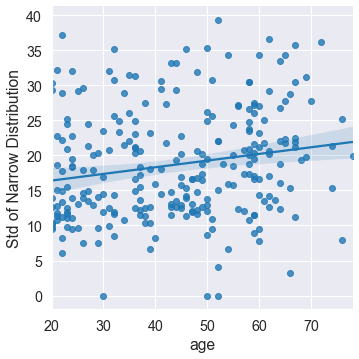

Kendal Tau: -0.1091279746091974 P: 0.009987196059378556
Pearson R: -0.14300828969553073 P: 0.021577626686251544


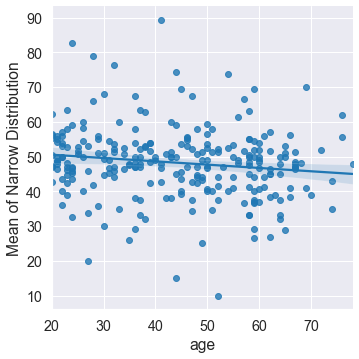

USIDep
Normality AQ Statistics=0.839, p=0.000
Normality stds Statistics=0.974, p=0.000
Kendal Tau: -0.05414373386829543 P: 0.23687680815648482
Pearson R: -0.06806363774254537 P: 0.2760573897205638


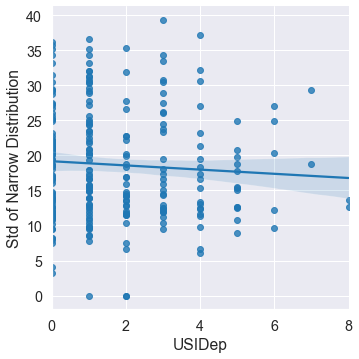

Kendal Tau: -0.07958158617815607 P: 0.08319747757572013
Pearson R: -0.08977824174653405 P: 0.15044679806030165


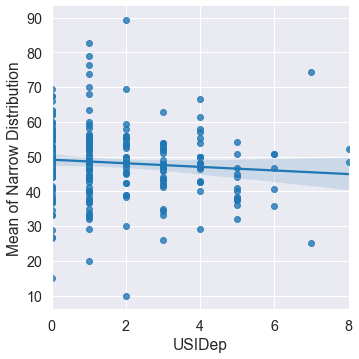

NEW DIST skew 

age
Normality AQ Statistics=0.953, p=0.000
Normality stds Statistics=0.983, p=0.004
Kendal Tau: 0.1845561278955076 P: 1.2246265798499514e-05
Pearson R: 0.2694720038794245 P: 1.1397791346594327e-05


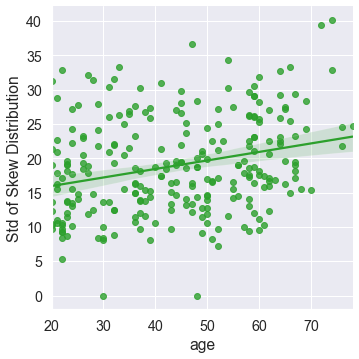

Kendal Tau: -0.07339914769617949 P: 0.08255253114556643
Pearson R: -0.09008372469606732 P: 0.14905769027006102


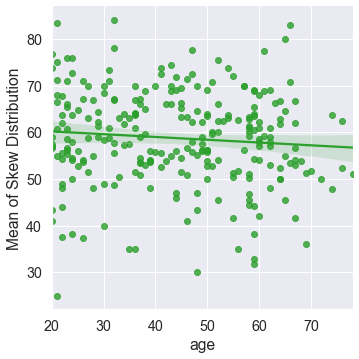

USIDep
Normality AQ Statistics=0.839, p=0.000
Normality stds Statistics=0.983, p=0.004
Kendal Tau: -0.07330312687025721 P: 0.10922289876057256
Pearson R: -0.07045606396716818 P: 0.25948950276050836


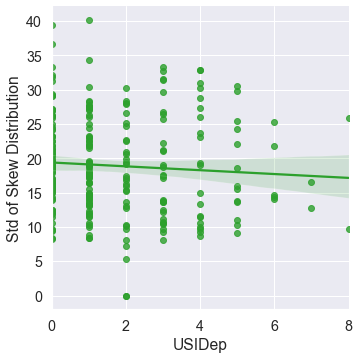

Kendal Tau: -0.06708421389579572 P: 0.14343086784400094
Pearson R: -0.0817507926556793 P: 0.1905587748048231


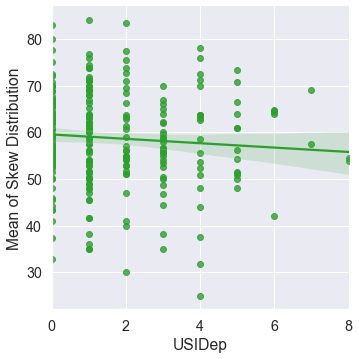

NEW DIST wide 

age
Normality AQ Statistics=0.953, p=0.000
Normality stds Statistics=0.963, p=0.000
Kendal Tau: -0.22678068527833123 P: 7.700529091591795e-08
Pearson R: -0.3019177733537308 P: 7.741552044212583e-07


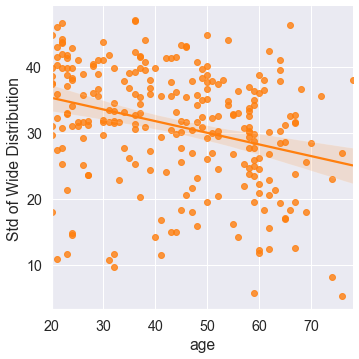

Kendal Tau: -0.033760462506066714 P: 0.42485048098938893
Pearson R: -0.026868873562935144 P: 0.6675157923917101


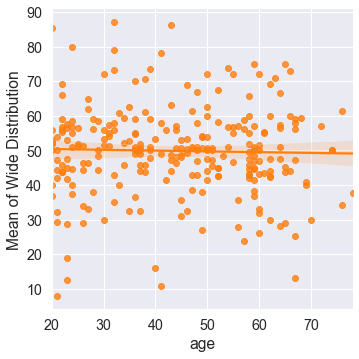

USIDep
Normality AQ Statistics=0.839, p=0.000
Normality stds Statistics=0.963, p=0.000
Kendal Tau: 0.06050809706178499 P: 0.18610194064002117
Pearson R: 0.09247890427456042 P: 0.13850147491664444


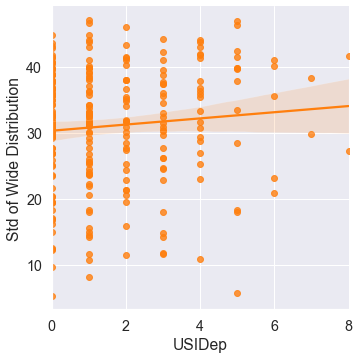

Kendal Tau: -0.003488106714479224 P: 0.9393943566469013
Pearson R: 0.00706983642983639 P: 0.9100239087396275


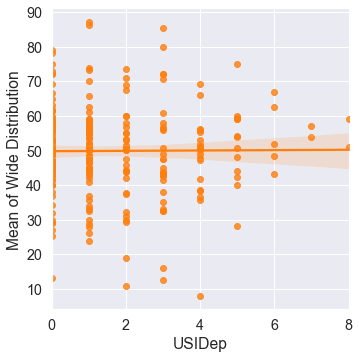

In [41]:
from scipy.stats import pearsonr, spearmanr, kendalltau, zscore, shapiro
sns.set(font_scale=1.3)

for dist in sub_df['dist'].unique():
    if dist=='narrow':
        color=[plt.cm.tab10(0)]
    if dist=='wide':
        color=[plt.cm.tab10(1)]
    if dist=='skew':
        color=[plt.cm.tab10(2)]
    print('NEW DIST', dist, '\n')
    plt_df=sub_df[sub_df['dist'].isin([dist])]
    plt_df=plt_df.groupby(by='sub').mean()
    for aq in [aq for aq in ['age','USIDep']]:
        print(aq)
        stat, p = shapiro(plt_df[aq])
        print('Normality AQ Statistics=%.3f, p=%.3f' % (stat, p))
        stat, p = shapiro(plt_df['stds'])
        print('Normality stds Statistics=%.3f, p=%.3f' % (stat, p))
        
        with sns.axes_style("darkgrid"):
            r,p=kendalltau(plt_df[aq],plt_df['stds'])
            print("Kendal Tau: %s P: %s"%(r,p))
            r,p=pearsonr(plt_df[aq],plt_df['stds'])
            print("Pearson R: %s P: %s"%(r,p))
            ax=sns.lmplot(x=aq,y='stds',data=plt_df,order=1,
                       line_kws={'color': color[0]}, scatter_kws={'color': color})
            ax.set_ylabels('Std of %s Distribution'%(dist.capitalize()))
            ax.set_xlabels('%s'%(aq.replace("_", " ")))
            plt.show()
            r,p=kendalltau(plt_df[aq],plt_df['means'])
            print("Kendal Tau: %s P: %s"%(r,p))
            r,p=pearsonr(plt_df[aq],plt_df['means'])
            print("Pearson R: %s P: %s"%(r,p))
            ax=sns.lmplot(x=aq,y='means',data=plt_df,order=1,
                       line_kws={'color': color[0]}, scatter_kws={'color': color})
            ax.set_ylabels('Mean of %s Distribution'%(dist.capitalize()))
            ax.set_xlabels('%s'%(aq.replace("_", " ")))
            plt.savefig("Figures/H3b_%s_%s.svg"%(dist,aq))
            plt.show()

,index_x,dist,narrow_first,means,stds,skew,sub,index_y,USIDep,AQ_Social,...,age,education,sex,race,(Intercept)_x,per_x,(Intercept)_y,per_y,(Intercept),per
2,2,wide,-1.0,48.000000,36.292463,0.123724,sub-5858b2ca83a02d0001e38fd2,111,1,4.2,...,44,Bachelor's Degree,Male,White / Caucasian,-46.869410,93.313178,-46.869410,93.313178,-39.308963,79.440368
5,2,wide,-1.0,50.625000,33.159966,-0.150303,sub-5c7e764fa7432a00169e1499,407,1,5.2,...,44,Bachelor's Degree,Male,Black or African American,-47.341955,95.679455,-47.341955,95.679455,-35.398923,70.832161
12,2,wide,2.0,38.235294,28.864426,0.235292,sub-5fb16308dc5973607fa3041c,51,4,6.4,...,59,"High school graduate, diploma or the equivalent",Female,White / Caucasian,-12.213238,29.515826,-12.213238,29.515826,-16.025112,38.585211
13,2,wide,2.0,38.235294,28.864426,0.235292,sub-5fb16308dc5973607fa3041c,455,4,6.4,...,59,"High school graduate, diploma or the equivalent",Female,White / Caucasian,-12.213238,29.515826,-12.213238,29.515826,-16.025112,38.585211
14,2,wide,2.0,38.235294,28.864426,0.235292,sub-5fb16308dc5973607fa3041c,520,4,6.4,...,59,"High school graduate, diploma or the equivalent",Female,White / Caucasian,-12.213238,29.515826,-12.213238,29.515826,-16.025112,38.585211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366,2,wide,1.0,61.250000,21.671245,-0.549167,sub-628fb4c3880a08418cedd2d2,188,0,5.2,...,47,Associates Degree,Male,Black or African American,-31.744282,63.136711,-31.744282,63.136711,-13.447764,25.661869
1367,2,wide,1.0,61.250000,21.671245,-0.549167,sub-628fb4c3880a08418cedd2d2,241,0,5.2,...,47,Associates Degree,Male,Black or African American,-31.744282,63.136711,-31.744282,63.136711,-13.447764,25.661869
1370,2,wide,-1.0,50.000000,32.366944,0.000000,sub-5fea025ffeba314a5f1fbda8,414,1,4.2,...,21,Bachelor's Degree,Male,White / Caucasian,-41.650601,83.239487,-41.650601,83.239487,-38.013724,80.421843
1375,2,wide,1.0,47.600000,15.620499,-0.136547,sub-614fca8245a450546842e487,30,1,6.2,...,62,Associates Degree,Female,White / Caucasian,-31.831063,64.027763,-31.831063,64.027763,-28.224208,62.173051


NEW DIST narrow 



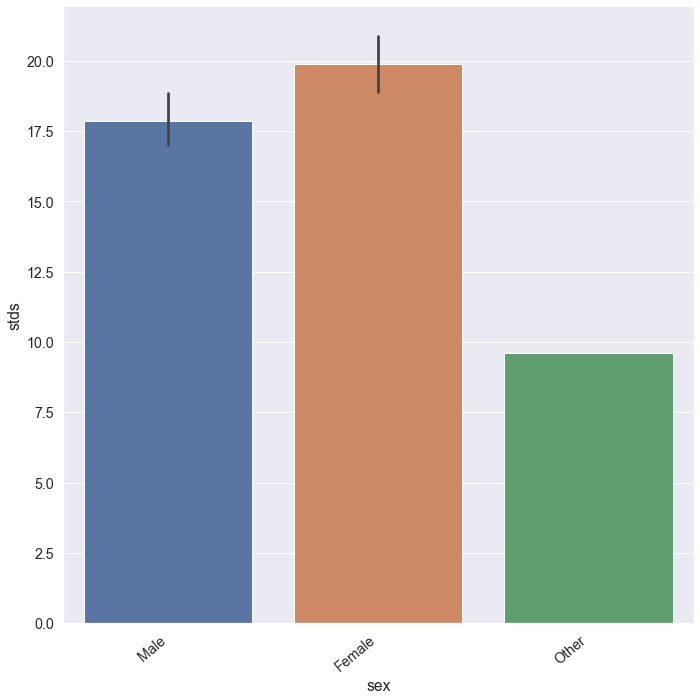

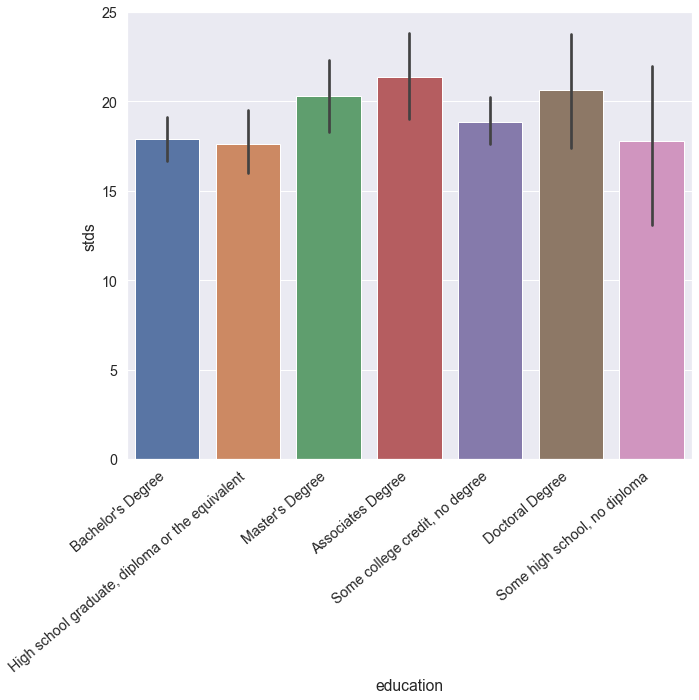

NEW DIST skew 



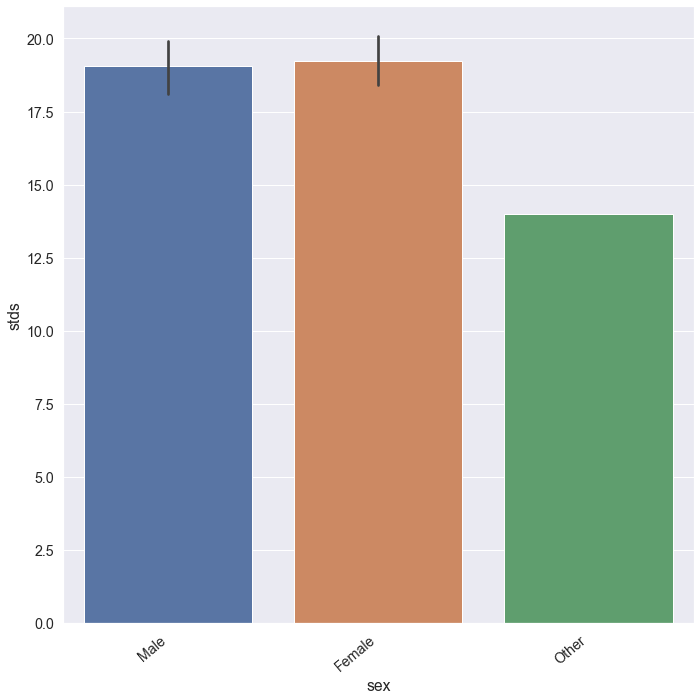

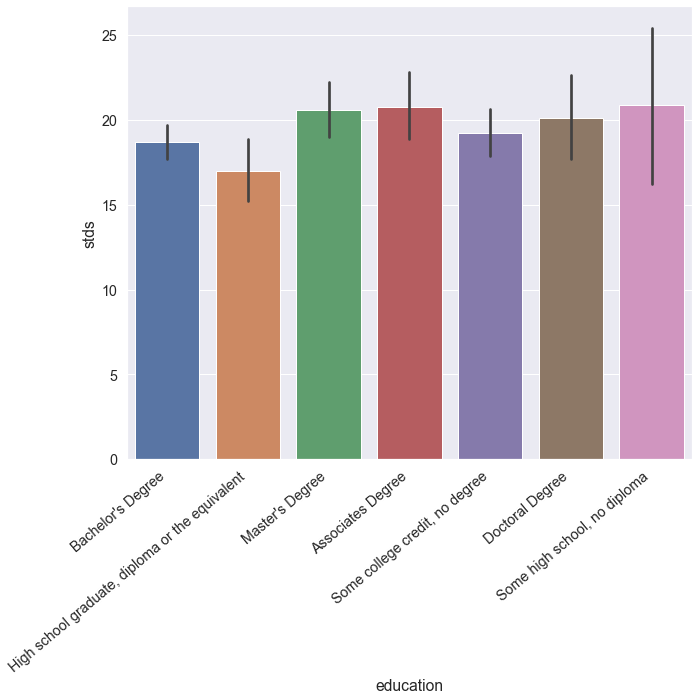

NEW DIST wide 



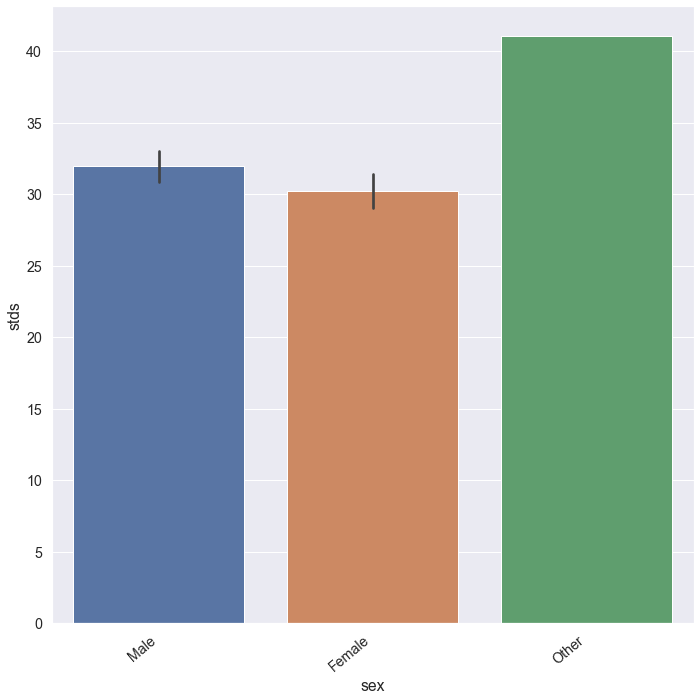

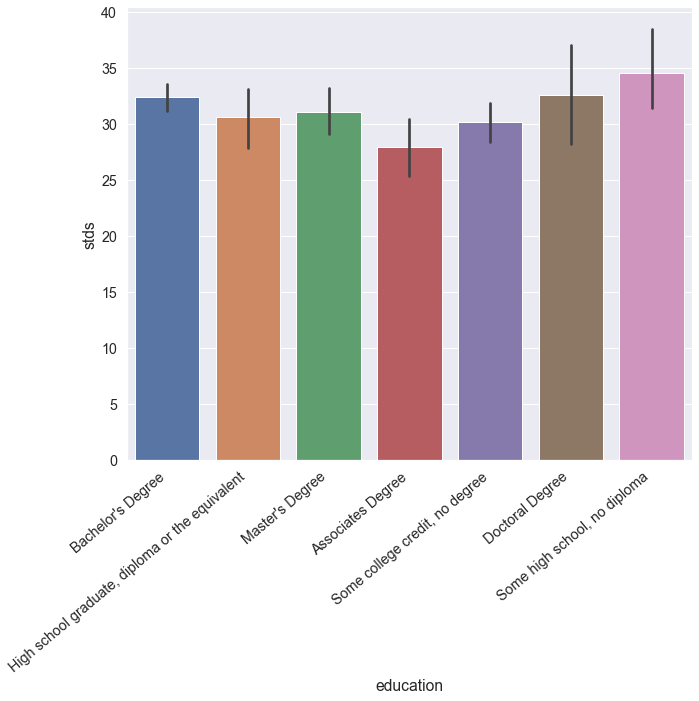

In [51]:
from scipy.stats import ttest_ind,kruskal

for dist in sub_df['dist'].unique():
    if dist=='narrow':
        color=[plt.cm.tab10(0)]
    if dist=='wide':
        color=[plt.cm.tab10(1)]
    if dist=='skew':
        color=[plt.cm.tab10(2)]
    print('NEW DIST', dist, '\n')
    plt_df=sub_df[sub_df['dist'].isin([dist])]
    for aq in [aq for aq in ['sex','education']]:
        
        with sns.axes_style("darkgrid"):
            
            fig, ax = plt.subplots(figsize=[10,10])
            sns.barplot(x=aq,y='stds',ax=ax,data=plt_df,)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
            plt.tight_layout()
            plt.show()


In [23]:
sub_df

,index_x,dist,narrow_first,means,stds,skew,sub,index_y,USIDep,AQ_Social,...,AQ_Imagine,AQ_total,age,education,sex,race,(Intercept)_x,per_x,(Intercept)_y,per_y
0,0,narrow,-1.0,50.000000,33.166248,0.000000,sub-5858b2ca83a02d0001e38fd2,111,1,4.2,...,4.2,25.8,44,Bachelor's Degree,Male,White / Caucasian,-47.212826,94.003686,-47.212826,94.003686
1,1,skew,-1.0,71.764706,14.677915,-0.209272,sub-5858b2ca83a02d0001e38fd2,111,1,4.2,...,4.2,25.8,44,Bachelor's Degree,Male,White / Caucasian,-47.212826,94.003686,-47.212826,94.003686
2,2,wide,-1.0,48.000000,36.292463,0.123724,sub-5858b2ca83a02d0001e38fd2,111,1,4.2,...,4.2,25.8,44,Bachelor's Degree,Male,White / Caucasian,-47.212826,94.003686,-47.212826,94.003686
3,0,narrow,-1.0,50.000000,33.166248,0.000000,sub-5858b2ca83a02d0001e38fd2,111,1,4.2,...,4.2,25.8,44,Bachelor's Degree,Male,White / Caucasian,-47.212826,94.003686,-47.212826,94.003686
4,1,skew,-1.0,73.559322,14.234818,-0.403118,sub-5858b2ca83a02d0001e38fd2,111,1,4.2,...,4.2,25.8,44,Bachelor's Degree,Male,White / Caucasian,-47.212826,94.003686,-47.212826,94.003686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719,0,narrow,1.0,52.057143,37.513172,-0.064827,sub-614fca8245a450546842e487,503,1,6.2,...,5.8,28.0,62,Associates Degree,Female,White / Caucasian,-31.912993,64.197256,-31.912993,64.197256
2720,1,skew,1.0,72.898551,13.514856,-2.133116,sub-614fca8245a450546842e487,30,1,6.2,...,5.8,28.0,62,Associates Degree,Female,White / Caucasian,-31.912993,64.197256,-31.912993,64.197256
2721,1,skew,1.0,72.898551,13.514856,-2.133116,sub-614fca8245a450546842e487,503,1,6.2,...,5.8,28.0,62,Associates Degree,Female,White / Caucasian,-31.912993,64.197256,-31.912993,64.197256
2722,2,wide,1.0,48.167939,10.727501,-0.841387,sub-614fca8245a450546842e487,30,1,6.2,...,5.8,28.0,62,Associates Degree,Female,White / Caucasian,-31.912993,64.197256,-31.912993,64.197256
